# Gated recurrent units (GRUs) model

---
Copyright Statement:

Author: Ratta Chindasilpa
Author's email: raththar@hotmail.com

This code is part of the master's thesis of Ratta Chindasilpa, "Deep Reinforcement Learning for Adaptive Control of Heater Position and Heating Power in a Smart Greenhouse," developed at Wageningen University and Research.

---

# Import library

In [1]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import GRU, Dense, Input, Reshape, Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.models import load_model # type: ignore

# Build the GRUs model
The Gated Recurrent Units (GRUs) model to predict the temperature for 64 zones (ZONE_0_0 to ZONE_7_7).

`master_weather_df` information: <class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 99 columns):
dtypes: float64(70), int32(4), int64(24), object(1)
memory usage: 38.9+ MB

1. Inputs: Only current "month", "day", and, "hour"
    - For example, the current state is
        * month = 1
        * day = 1
        * hour = 1
2. Output: Predicted next 6 steps of Temperatures for 64 zones (ZONE_0_0 to ZONE_7_7) in a list of lists
    - For example, the predicted next 6 temperature steps:
        * predicted_temp = [[ZONE_0_0 to ZONE_7_7], [ZONE_0_0 to ZONE_7_7], [ZONE_0_0 to ZONE_7_7], [ZONE_0_0 to ZONE_7_7], [ZONE_0_0 to ZONE_7_7], [ZONE_0_0 to ZONE_7_7]]

3. For instance use case,
    - Input: 
        - month = 1
        - day = 1
        - hour = 1
    - Output:
        - predicted_temp [a list of lists]: 
            - month=1, day=2, hour=2: [ZONE_0_0 to ZONE_7_7]
            - month=1, day=2, hour=3: [ZONE_0_0 to ZONE_7_7]
            - month=1, day=2, hour=4: [ZONE_0_0 to ZONE_7_7]
            - month=1, day=2, hour=5: [ZONE_0_0 to ZONE_7_7]
            - month=1, day=2, hour=6: [ZONE_0_0 to ZONE_7_7]
            - month=1, day=2, hour=7: [ZONE_0_0 to ZONE_7_7]

**Steps**
1. Split training and test set
    - X_train = columns 'month', 'day', 'hour' of year 2018 and 2022
    - y_train = columns 'ZONE_0_0' to 'ZONE_7_7' of year 2018 and 2022
    - X test = columns 'month', 'day', 'hour' of year 2023
    - y_test = columns 'ZONE_0_0' to 'ZONE_7_7' of year 2023
2. Train the GRUs model
3. Evaluate the model by using
    - Root mean square error (RMSE)
    - R-square
4. Save the GRUs model (.keras)

### Split the dataset into training (2018 to 2022) and testing (2023)

In [2]:
# Load the data
master_weather_df = pd.read_csv("datasets/master_weather_df.csv")

# Filter training and testing data based on year
train_df = master_weather_df[master_weather_df['year'].isin([2018, 2019, 2020, 2021, 2022])]
test_df = master_weather_df[master_weather_df['year'] == 2023]

# Define features (X) and target (y)
features = ['month', 'day', 'hour']
zones = [f"ZONE_{i}_{j}" for i in range(8) for j in range(8)] # 64 zones

X_train = train_df[features].values
y_train = train_df[zones].values
X_test = test_df[features].values
y_test = test_df[zones].values

# Create sliding windows for y_train and y_test
def create_sequences(inputs, outputs, time_steps=6):
    X, y = [], []
    for i in range(len(inputs) - time_steps):
        X.append(inputs[i])
        y.append(outputs[i : i + time_steps])  # Collect the next `time_steps` outputs
    return np.array(X), np.array(y)

# Generate sequences for training and testing
X_train, y_train = create_sequences(X_train, y_train)
X_test, y_test = create_sequences(X_test, y_test)

# Reshape X for GRU input
X_train_reshaped = X_train.reshape((-1, 1, len(features)))
X_test_reshaped = X_test.reshape((-1, 1, len(features)))

# Verify shapes
print(f"X_train_reshaped shape: {X_train_reshaped.shape}")  # (samples, input_steps, 6)
print(f"X_test_reshaped shape: {X_test_reshaped.shape}")    # (samples, input_steps, 6)
print(f"y_train shape: {y_train.shape}")  # (samples, output_steps, 100)
print(f"y_test shape: {y_test.shape}")    # (samples, output_steps, 100)

X_train_reshaped shape: (43794, 1, 3)
X_test_reshaped shape: (8754, 1, 3)
y_train shape: (43794, 6, 64)
y_test shape: (8754, 6, 64)


## Train the GRUs model

In [3]:
# Build the GRU model
model = Sequential([
    Input(shape=(1, len(features))),  # Input: time steps = 1, features = 3
    GRU(256, activation='relu', return_sequences=True),  # First GRU layer
    Dropout(0.2),  # Dropout with 20% rate
    GRU(256, activation='relu', return_sequences=True),  # Second GRU layer
    Dropout(0.2),  # Dropout with 20% rate
    GRU(256, activation='relu', return_sequences=False),  # Third GRU layer
    Dropout(0.2),  # Dropout with 20% rate
    Dense(6 * len(zones)),  # Output: 6 future steps for 100 zones
    Reshape((6, len(zones)))  # Reshape to (6, 100)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 256)         │       200,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 1, 256)         │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 384)            │        98,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 64)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,088,640 (4.15 MB)

 Trainable params: 1,088,640 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
# Train the GRU model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

X_train_reshaped = X_train.reshape((-1, 1, len(features)))  # Reshape inputs for GRU
X_test_reshaped = X_test.reshape((-1, 1, len(features)))

history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 27.5839 - mae: 3.2333 - val_loss: 1.8852 - val_mae: 1.0677
Epoch 2/100
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.9428 - mae: 1.3490 - val_loss: 1.4407 - val_mae: 0.9419
Epoch 3/100
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.3269 - mae: 1.1953 - val_loss: 1.6368 - val_mae: 0.9858
Epoch 4/100
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.1320 - mae: 1.1476 - val_loss: 1.3335 - val_mae: 0.8938
Epoch 5/100
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.0443 - mae: 1.1204 - val_loss: 1.1796 - val_mae: 0.8358
Epoch 6/100
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.9526 - mae: 1.0926 - val_loss: 1.3630 - val_mae: 0.9230
Epoch 7/100
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.8273 - mae: 1.0568 - val_loss: 1.1160 - val_mae: 0.8115
Epoch 8/100
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.8038 - mae: 1.0468 - val_loss: 1.1028 - val_mae: 0.7953
Epoch 9/100
2190/2190 ━

## Evaluate the model

In [5]:
# Evaluate the model
y_pred = model.predict(X_test_reshaped)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1)))
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Compute R-Square
r_square = r2_score(y_test.reshape(-1), y_pred.reshape(-1))
print(f"R-Square: {r_square:.4f}")

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Root Mean Square Error (RMSE): 0.5178
R-Square: 0.9514


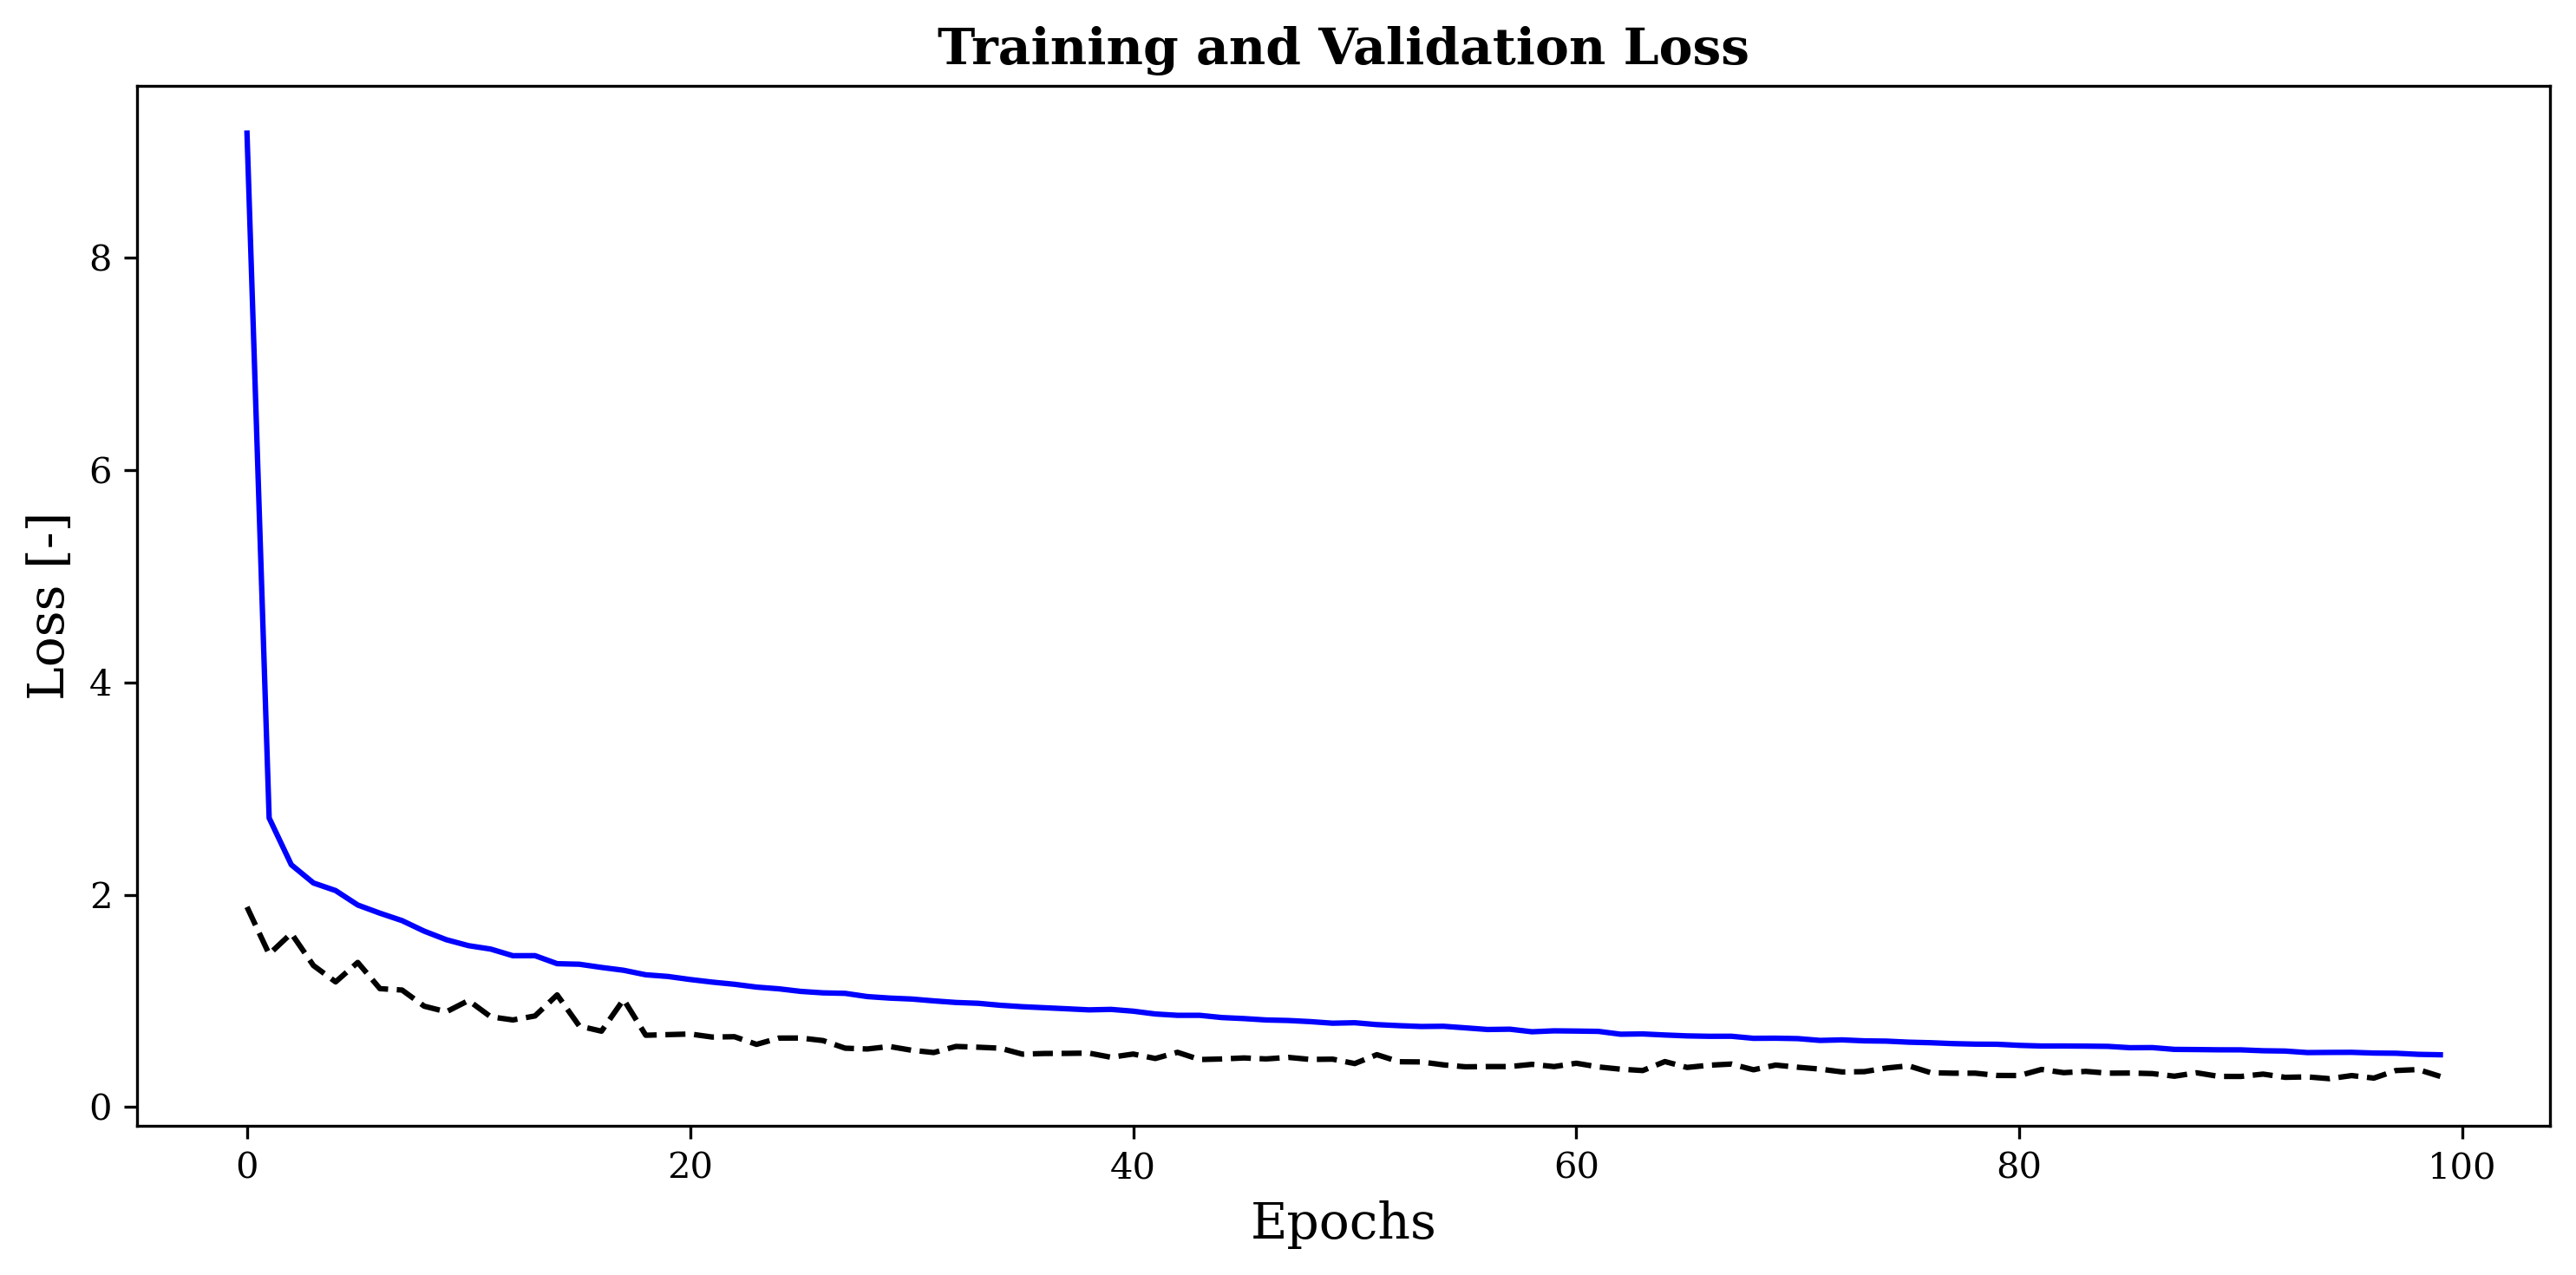

In [6]:
# Extract loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ['Computer Modern Sans Serif']
})

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
ax.plot(train_loss, 
        label='Training Loss',
        linestyle="-", 
        color="blue"
        )

ax.plot(val_loss, 
        linestyle="--", 
        label='Validation Loss',
        color="black"
        )

# Labels and title
ax.set_xlabel("Epochs", fontsize=14)
ax.set_ylabel("Loss [-]", fontsize=14)
ax.set_title("Training and Validation Loss", fontsize=14, fontweight='bold')

# Show plot
plt.tight_layout()
plt.show()

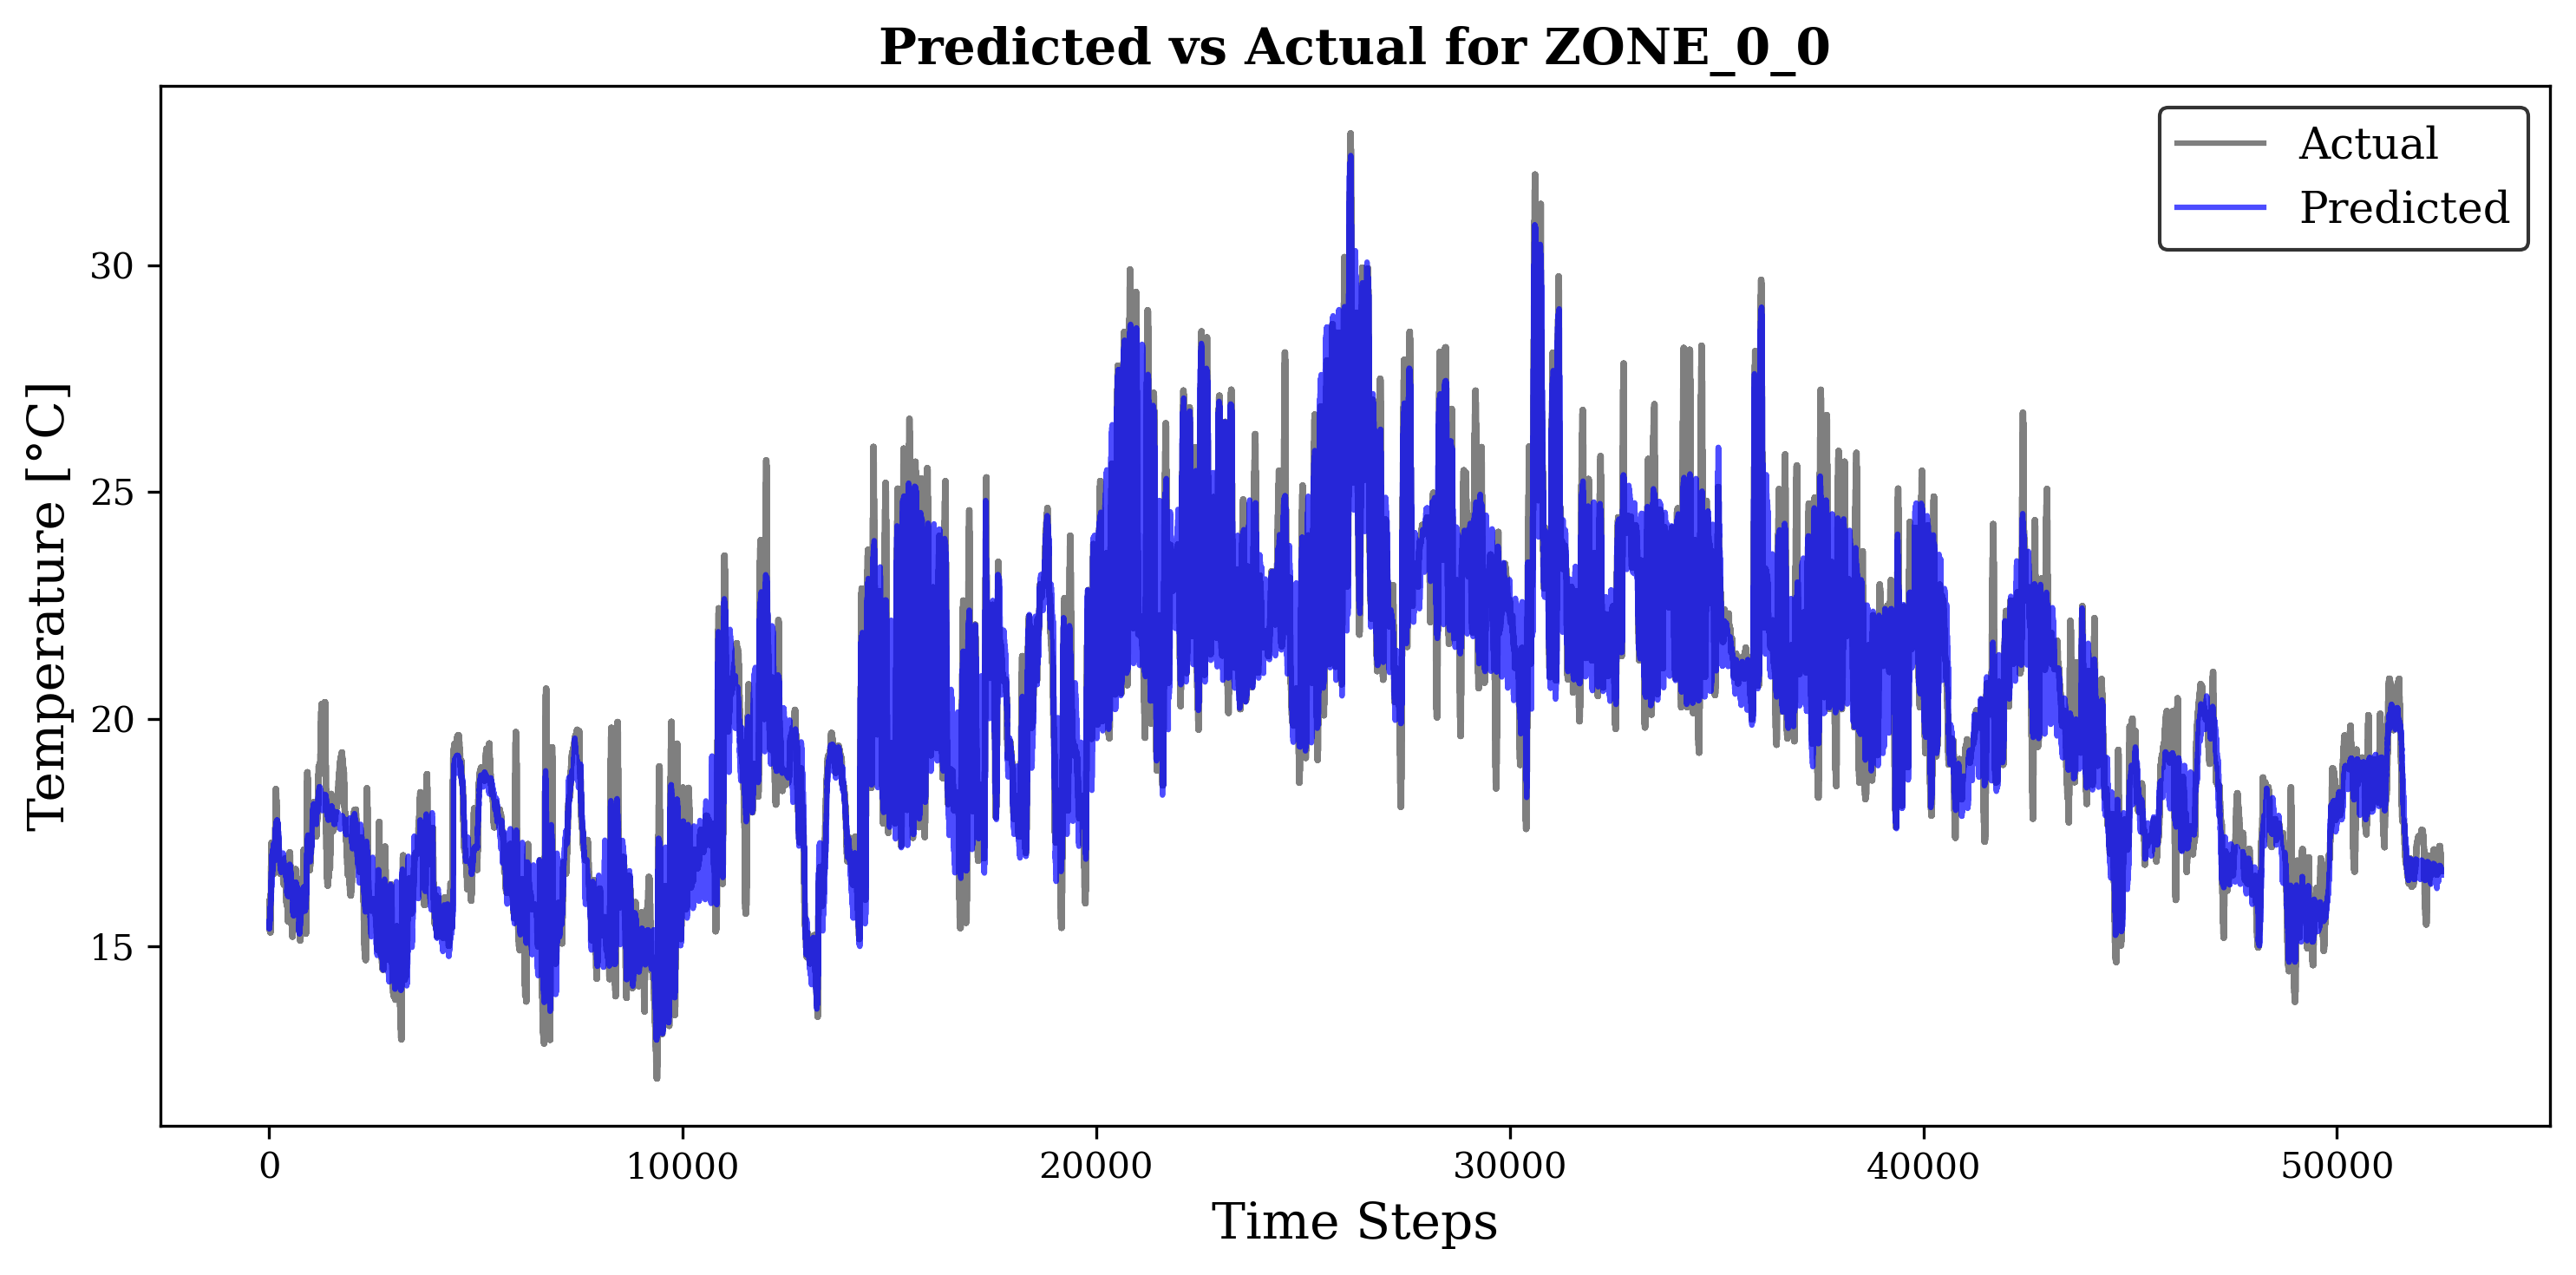

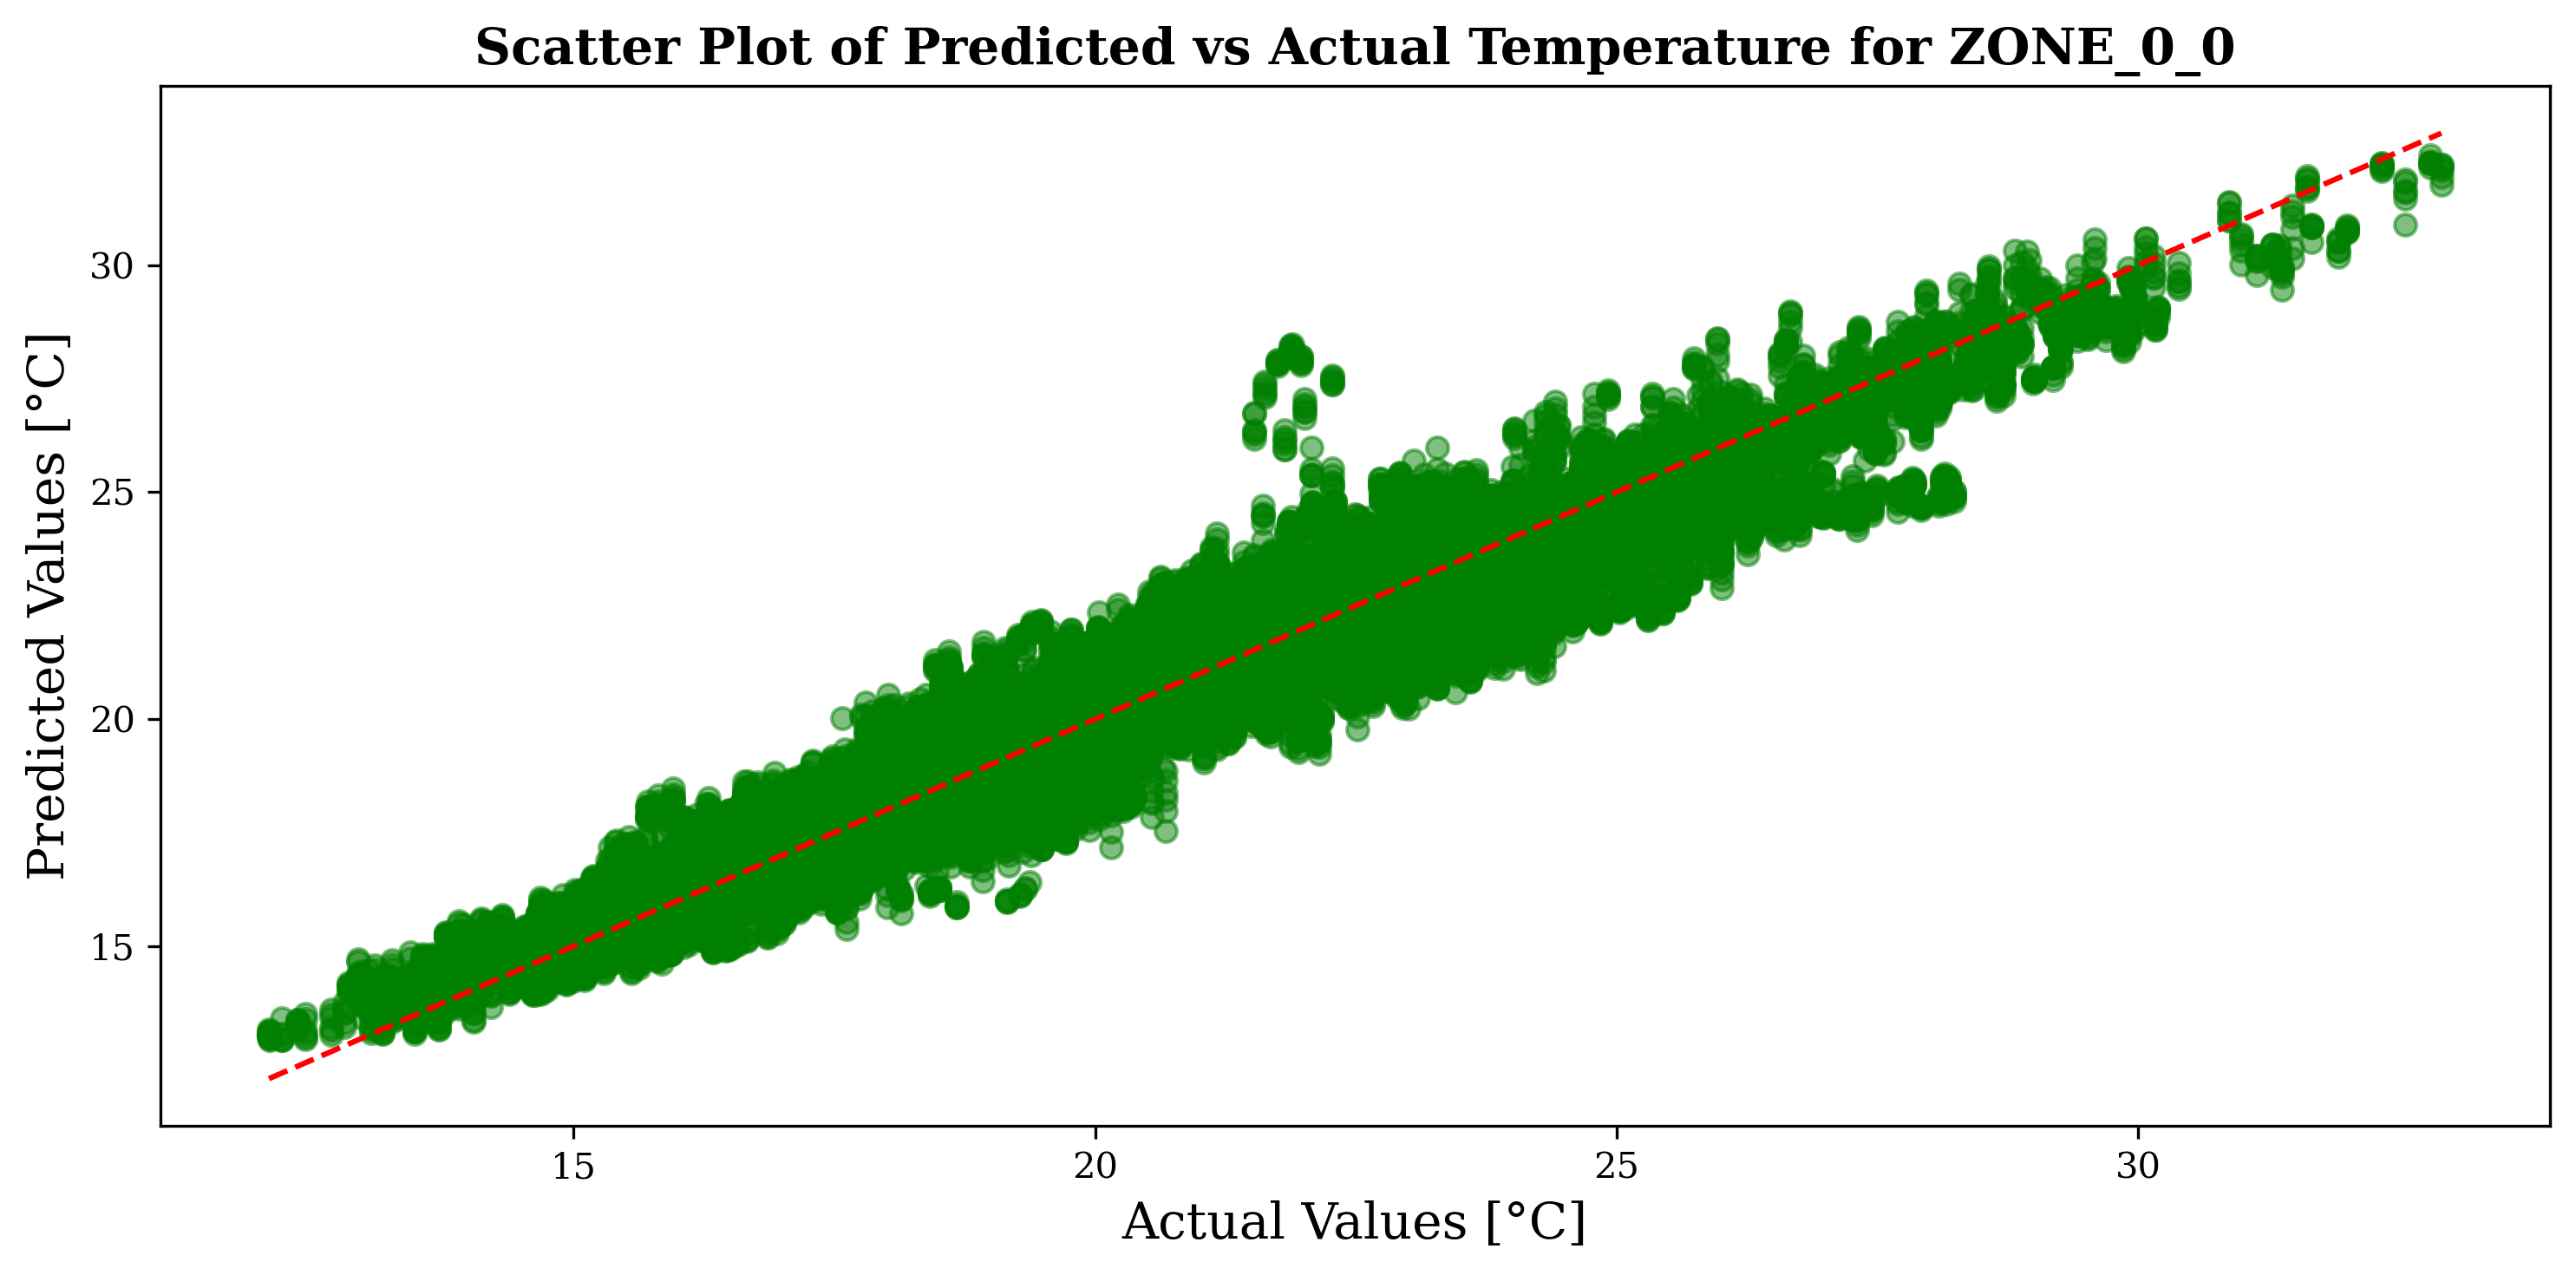

In [7]:
# Reshape y_pred and y_test to 2D arrays for comparison
y_pred_flat = y_pred.reshape(-1, len(zones))  # (samples * time_steps, 100)
y_test_flat = y_test.reshape(-1, len(zones))  # (samples * time_steps, 100)

# Select a specific zone to plot (e.g., 'ZONE_0_0')
zone_index = 0  # Index for ZONE_0_0
zone_name = zones[zone_index]

# Extract data for the selected zone
y_pred_zone = y_pred_flat[:, zone_index]
y_test_zone = y_test_flat[:, zone_index]

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ['Computer Modern Sans Serif']
})

# Plot y_pred vs y_test for the selected zone
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(y_test_zone, label='Actual', color='black', alpha=0.5)
plt.plot(y_pred_zone, label='Predicted', color='blue', alpha=0.7)
plt.title(f'Predicted vs Actual for {zone_name}', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Temperature [°C]', fontsize=14)
plt.legend(fontsize=12, edgecolor='black')
plt.tight_layout()
plt.show()

# Scatter plot for predicted vs actual
plt.figure(figsize=(10, 5), dpi=300)
plt.scatter(y_test_zone, y_pred_zone, alpha=0.5, color='green')
plt.title(f'Scatter Plot of Predicted vs Actual Temperature for {zone_name}', fontsize=14, fontweight='bold')
plt.xlabel('Actual Values [°C]', fontsize=14)
plt.ylabel('Predicted Values [°C]', fontsize=14)
plt.plot([min(y_test_zone), max(y_test_zone)], [min(y_test_zone), max(y_test_zone)], 'r--')  # Line y=x
plt.tight_layout()
plt.show()

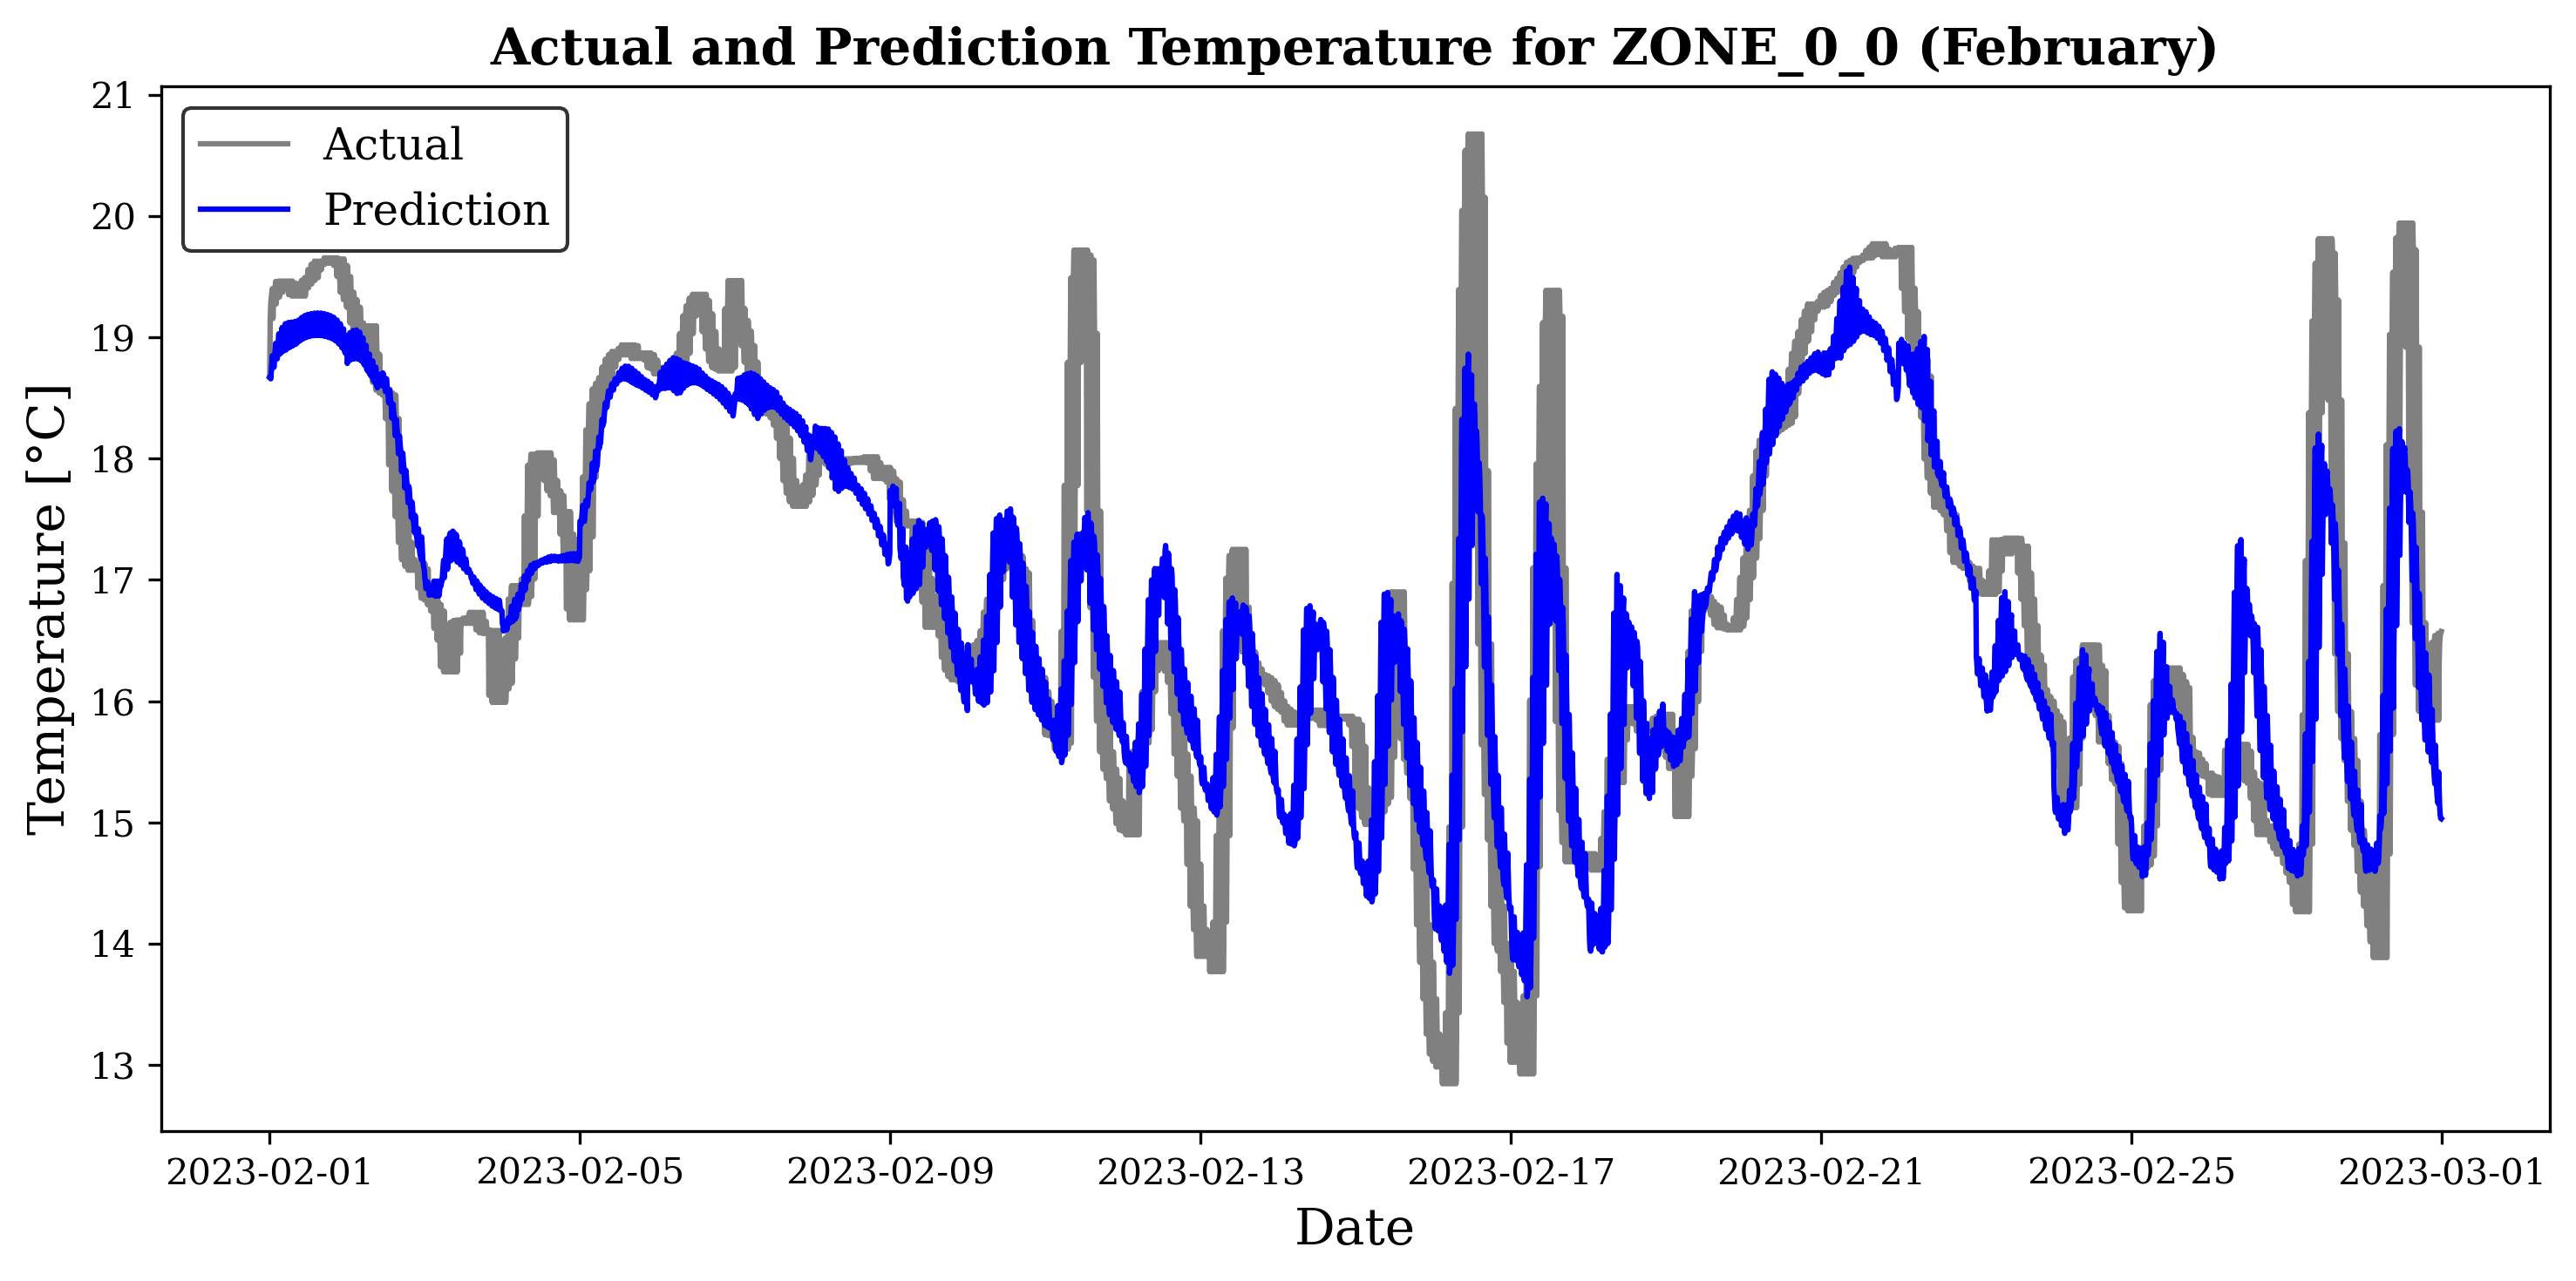

In [8]:
# Reshape y_pred and y_test to 2D arrays for comparison
y_pred_flat = y_pred.reshape(-1, len(zones))  # (samples * time_steps, 100)
y_test_flat = y_test.reshape(-1, len(zones))  # (samples * time_steps, 100)

# Select a specific zone to plot (e.g., 'ZONE_0_0')
zone_index = 0  # Index for ZONE_0_0
zone_name = zones[zone_index]

# Extract data for the selected zone
y_pred_zone = y_pred_flat[:, zone_index]
y_test_zone = y_test_flat[:, zone_index]

# Define starting datetime and interval
start_datetime = pd.Timestamp("2023-01-01 00:00")  # Starting point
time_interval = "10min"  # 10-minute interval between time steps

# Ensure correct number of periods (52524 for 10-minute intervals in 2023)
num_time_steps = 52524  # Total 10-minute intervals in 2023
if y_test_flat.shape[0] != num_time_steps:
    raise ValueError(f"Expected {num_time_steps} time steps for 2023, but got {y_test_flat.shape[0]}.")

# Generate datetime range for the year 2023
datetimes = pd.date_range(start=start_datetime, periods=num_time_steps, freq=time_interval)

# Create a DataFrame to hold datetime and temperature data
df_zone = pd.DataFrame({
    "datetime": datetimes,
    "y_test": y_test_zone[:num_time_steps],
    "y_pred": y_pred_zone[:num_time_steps]
})

# Filter for February only
df_zone_february = df_zone[df_zone["datetime"].dt.month == 2]

# Plot for February
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ['Computer Modern Sans Serif']
})

plt.figure(figsize=(10, 5), dpi=300)
plt.plot(df_zone_february["datetime"], df_zone_february["y_test"], label="Actual", color='grey')
plt.plot(df_zone_february["datetime"], df_zone_february["y_pred"], label="Prediction", color="blue")
plt.title(f"Actual and Prediction Temperature for {zone_name} (February)", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature [°C]", fontsize=14)
plt.legend(fontsize=12, edgecolor='black')
plt.tight_layout()
plt.show()

## Save the GRUs model (.keras)

In [9]:
# # Save the trained model
# model.save("gru_model.keras")
# print("Model saved as 'gru_model.keras'")

---

## Predict the next 6 steps

In [10]:
def predict_next_temp(model_path: str='gru_model.keras', 
                      month: int=1, 
                      day: int=1, 
                      hour: int=1):
    """
    Predict the next 6 steps temperature using a trained GRU model.

    Parameters:
        model_path (str): Path to the trained GRU model (.keras).
        month (int): Current month (1-12).
        day (int): Current day (1-31).
        hour (int): Current hour (1-24).

    Returns:
        list: A flattened list of next 6 steps temperature predictions.
    """
    # Load the trained GRU model
    model = load_model(model_path)

    # Prepare the input data
    # Input format: [month, day, hour], shaped as (1, 1, 3) for GRU input
    input_data = np.array([[month, day, hour]])  # Shape (1, 3)
    input_data = input_data.reshape(1, 1, 3)    # Reshape to (1, 1, features)

    # Make predictions
    predictions = model.predict(input_data)  # Shape (1, 3, 100)

    # Flatten the predictions for 6 steps
    predicted_temp = predictions.flatten().tolist()  # Flatten and convert to list

    return predicted_temp

In [11]:
# Path to the trained model
model_path = "gru_model.keras"

# Input parameters
month = 1
day = 1
hour = 1

# Call the function
predicted_temp = predict_next_temp(model_path, month, day, hour)

# Print the predicted temperatures
print(len(predicted_temp))
print("Predicted next 6 steps temperatures:", predicted_temp)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
384
Predicted next 6 steps temperatures: [15.68716049194336, 16.018592834472656, 16.185855865478516, 16.25160789489746, 16.24130630493164, 16.155229568481445, 15.966805458068848, 15.61243724822998, 16.0587158203125, 16.432674407958984, 16.61977195739746, 16.691621780395508, 16.679054260253906, 16.58194923400879, 16.372690200805664, 15.980262756347656, 16.248994827270508, 16.64336585998535, 16.839340209960938, 16.914648056030273, 16.900012969970703, 16.795913696289062, 16.574748992919922, 16.165990829467773, 16.32441520690918, 16.724796295166016, 16.923879623413086, 17.001188278198242, 16.985519409179688, 16.87771224975586, 16.651296615600586, 16.237640380859375, 16.313066482543945, 16.70975112915039, 16.90609359741211, 16.98218536376953, 16.96649742126465, 16.859298706054688, 16.634868621826172, 16.225788116455078, 16.215368270874023, 16.59964370727539, 16.786334991455078, 16.85726547241211, 16.841629028320312, 16.74012565612793, 16.52640342712402

### Compare master_weather_df and GRUs model

In [12]:
# Function to create predicted DataFrame with adjusted timestamps
def create_predicted_dataframe(predicted_temp, start_month, start_day, start_hour):
    """
    Create a DataFrame for the predicted temperatures with proper timestamps.

    Parameters:
        predicted_temp (list): Flattened list of predicted temperatures.
        start_month (int): Starting month (1-12).
        start_day (int): Starting day (1-31).
        start_hour (int): Starting hour (1-24).

    Returns:
        pd.DataFrame: Predicted DataFrame with year, month, day, hour, and temperature columns.
    """
    # Days in each month
    days_in_month = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30,
                     7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

    # Start from the next hour
    start_hour += 1
    if start_hour > 24:  # Handle hour overflow
        start_hour = 1
        start_day += 1
        if start_day > days_in_month[start_month]:
            start_day = 1
            start_month += 1
            if start_month > 12:
                start_month = 1

    # Create timestamps for the next 6 steps
    timestamps = []
    for i in range(6):
        timestamps.append({'year': 2023, 'month': start_month, 'day': start_day, 'hour': start_hour})

        # Increment the hour and handle overflow
        start_hour += 1
        if start_hour > 24:
            start_hour = 1
            start_day += 1
            if start_day > days_in_month[start_month]:
                start_day = 1
                start_month += 1
                if start_month > 12:
                    start_month = 1

    # Split the predicted temperatures into zones (64 zones per step)
    zone_columns = [f"ZONE_{i}_{j}" for i in range(8) for j in range(8)]
    predicted_temps_reshaped = np.array(predicted_temp).reshape(6, len(zone_columns))  # Shape (6, 100)

    # Create the DataFrame
    timestamps_df = pd.DataFrame(timestamps)
    predicted_df = pd.DataFrame(predicted_temps_reshaped, columns=zone_columns)
    predicted_df = pd.concat([timestamps_df, predicted_df], axis=1)

    # Add a 'type' column
    predicted_df['type'] = 'Prediction'

    return predicted_df

# Load historical data
master_weather_df = pd.read_csv("datasets/master_weather_df.csv")

# Filter historical data for February 2023
history_df = master_weather_df[
    (master_weather_df['year'] == 2023) &
    (master_weather_df['month'] == 2) &
    (master_weather_df['day'] == 28)
][['year', 'month', 'day', 'hour', 'type'] + [f"ZONE_{i}_{j}" for i in range(8) for j in range(8)]]

# Set 'type' column to 'history' for historical data
history_df['type'] = 'History'

# Generate predictions
model_path = "gru_model.keras"
predicted_temp = predict_next_temp(model_path, month=2, day=28, hour=18)
predicted_df = create_predicted_dataframe(predicted_temp, start_month=2, start_day=28, start_hour=18)

# Combine historical and predicted data
combined_df = pd.concat([history_df, predicted_df], ignore_index=True)

combined_df.tail(12)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


,year,month,day,hour,type,ZONE_0_0,ZONE_0_1,ZONE_0_2,ZONE_0_3,ZONE_0_4,...,ZONE_6_6,ZONE_6_7,ZONE_7_0,ZONE_7_1,ZONE_7_2,ZONE_7_3,ZONE_7_4,ZONE_7_5,ZONE_7_6,ZONE_7_7
18,2023,2,28,19,History,17.557149,17.829223,17.856473,17.764643,17.614735,...,17.047269,16.615695,17.114733,17.341500,17.345474,17.245177,17.101638,16.921682,16.668694,16.239455
19,2023,2,28,20,History,16.645818,17.006607,17.132994,17.129038,17.037135,...,16.739099,16.254177,16.388289,16.712222,16.821054,16.811948,16.724750,16.562977,16.291008,15.810012
20,2023,2,28,21,History,16.132976,16.549457,16.719583,16.753110,16.690144,...,16.541088,16.018462,15.963310,16.352333,16.509796,16.538763,16.477578,16.326312,16.046765,15.535210
21,2023,2,28,22,History,15.917978,16.331696,16.522160,16.573498,16.522237,...,16.431722,15.906842,15.800724,16.188606,16.367841,16.415140,16.364939,16.217167,15.936409,15.444523
22,2023,2,28,23,History,15.856024,16.222067,16.409302,16.469443,16.427370,...,16.368777,15.890584,15.786575,16.132836,16.310443,16.366869,16.325477,16.186187,15.924359,15.486095
23,2023,2,28,24,History,15.843108,16.166725,16.341002,16.402828,16.369407,...,16.337520,15.888671,15.765468,16.084598,16.253783,16.312837,16.279865,16.153794,15.912353,15.505746
24,2023,2,28,19,Prediction,17.221193,17.365498,17.413151,17.407593,17.364780,...,17.086592,16.799070,16.916119,17.041380,17.076504,17.063440,17.019039,16.938889,16.797806,16.543695
25,2023,2,28,20,Prediction,16.941273,17.152973,17.235046,17.246399,17.209602,...,16.985006,16.667286,16.668602,16.862173,16.933090,16.937872,16.899899,16.816679,16.661518,16.375315
26,2023,2,28,21,Prediction,16.631969,16.901464,17.016813,17.044828,17.013599,...,16.875198,16.521709,16.419004,16.674767,16.781796,16.804777,16.772758,16.685196,16.513424,16.192408
27,2023,2,28,22,Prediction,16.340023,16.644369,16.786869,16.830835,16.804932,...,16.762455,16.371481,16.197721,16.493464,16.630461,16.670822,16.644444,16.551586,16.363003,16.014526


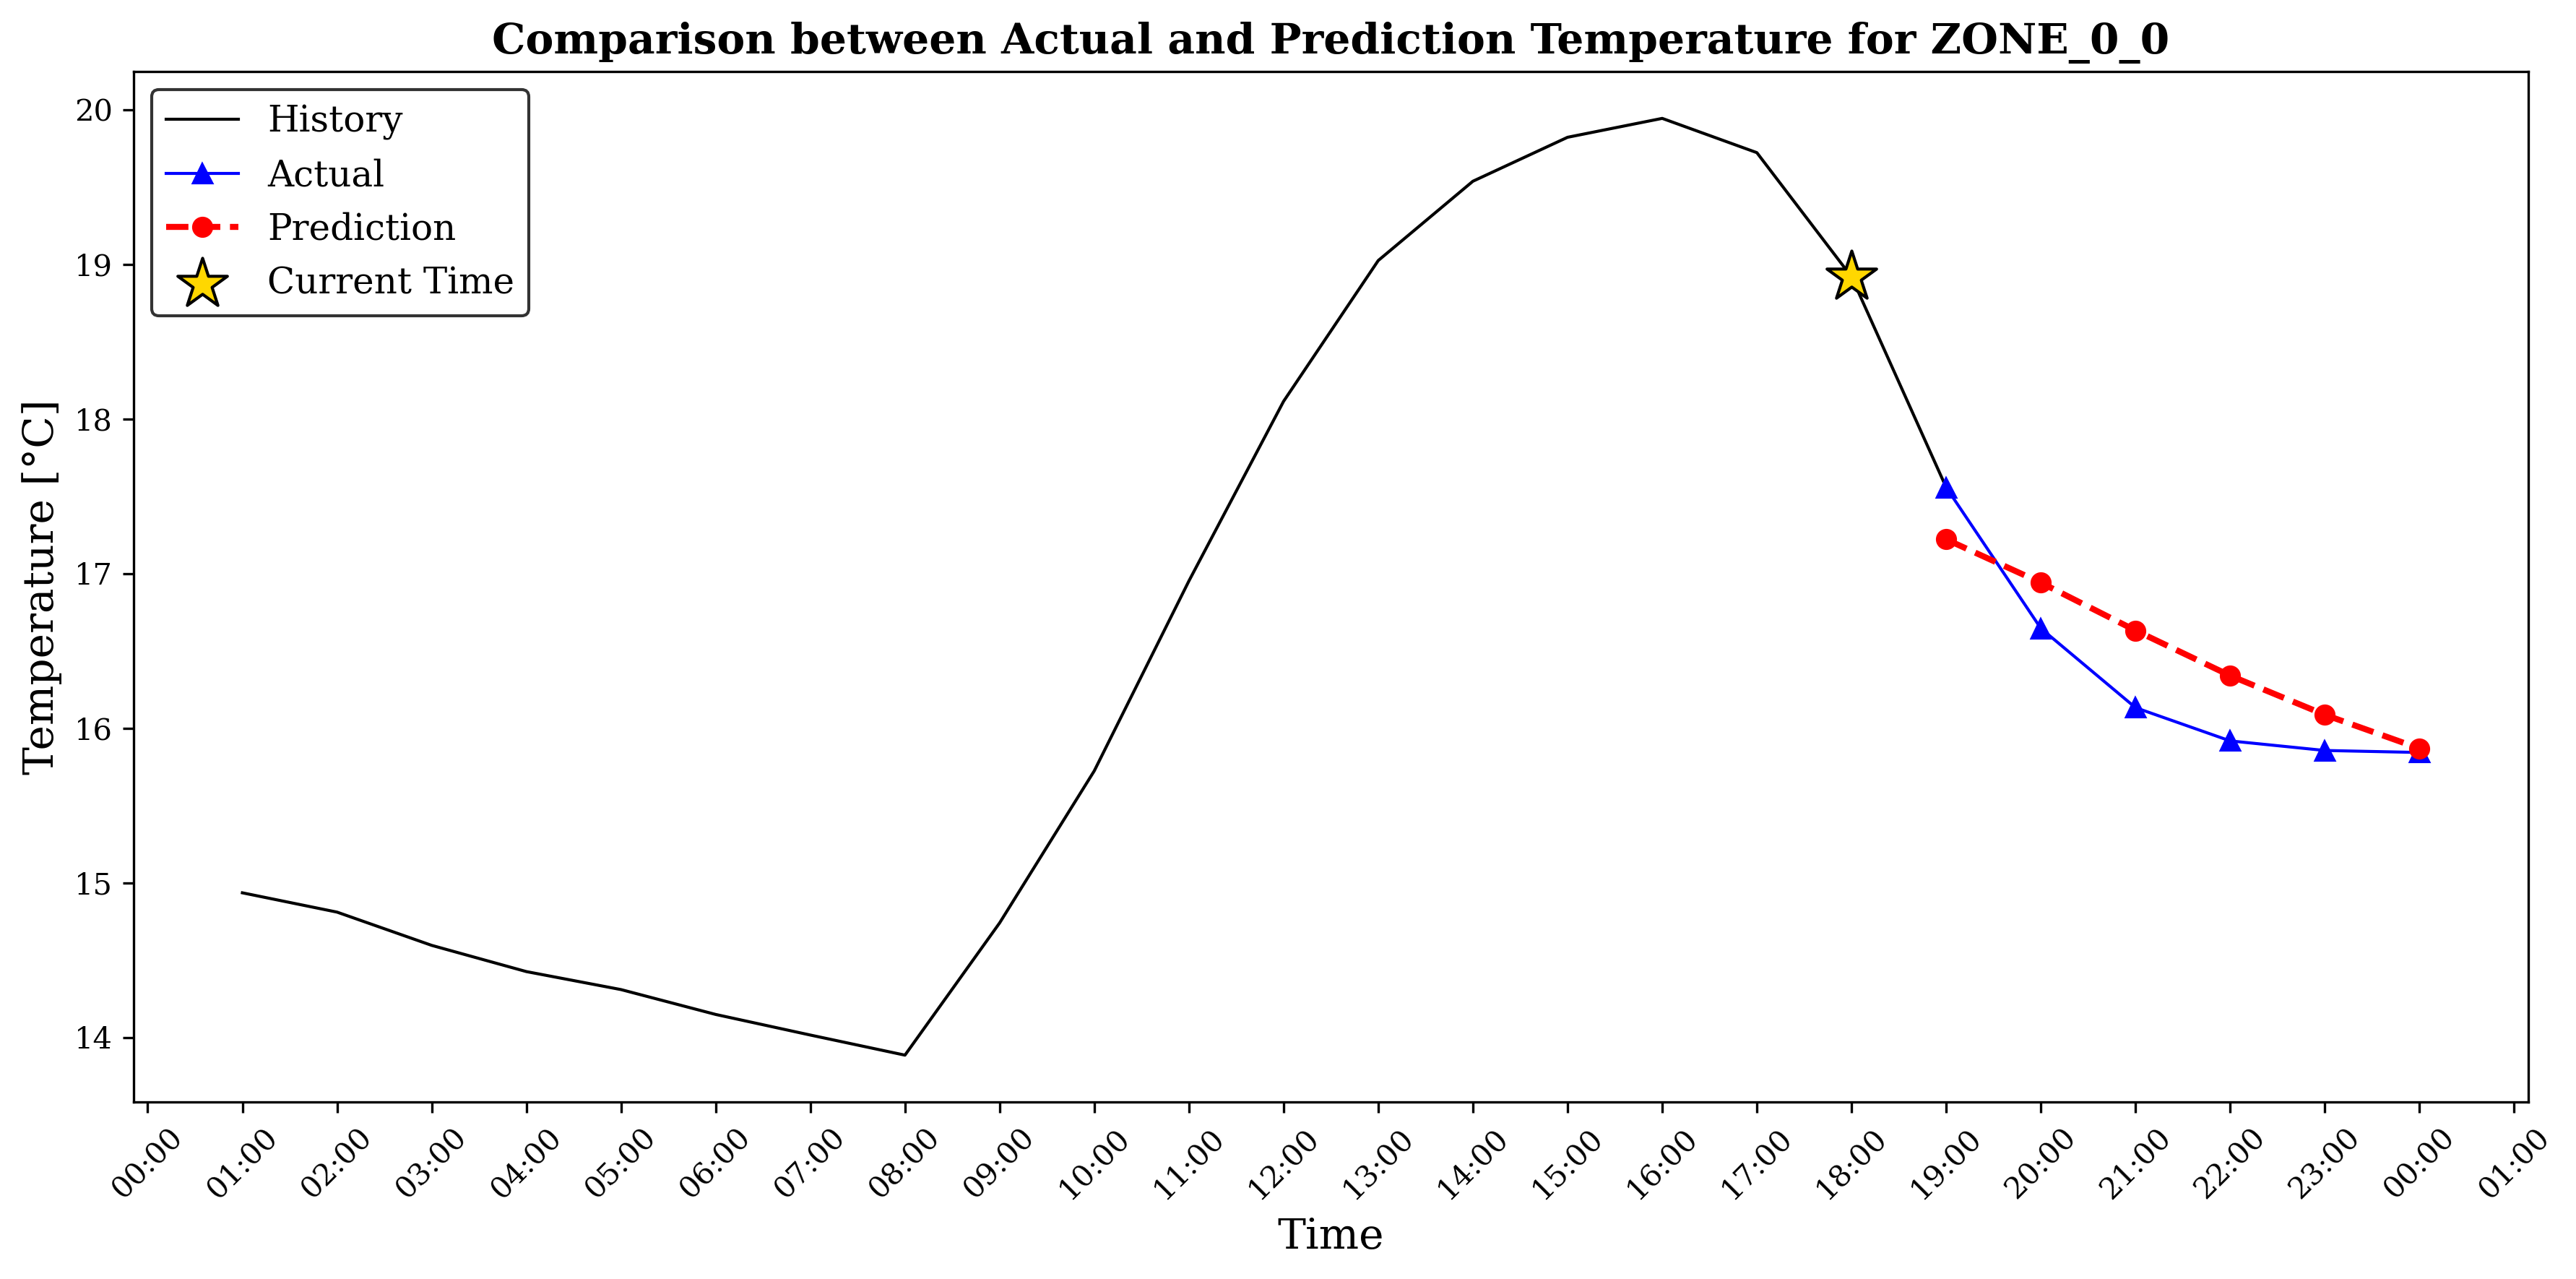

In [13]:
# Convert datetime for filtering
history_df['datetime'] = pd.to_datetime(history_df[['year', 'month', 'day', 'hour']])
predicted_df['datetime'] = pd.to_datetime(predicted_df[['year', 'month', 'day', 'hour']])

# Define key time points
prediction_start_time = predicted_df['datetime'].min()  # First timestamp of prediction
current_time = pd.Timestamp("2023-02-28 18:00")  # The time to mark

# Define key time points
prediction_start_time = predicted_df['datetime'].min()  # First timestamp of prediction

# Splitting history into two parts:
# 1. History before prediction starts (Black)
history_before_pred = history_df[history_df['datetime'] < prediction_start_time]

# 2. True Values (Blue) start from the same point as Prediction
history_after_transition = history_df[history_df['datetime'] >= prediction_start_time]

# Ensure smooth transition: Extend black line without shifting blue values
history_black_extended = pd.concat([history_before_pred, history_after_transition.iloc[:1]])  # Extend black to first blue point

# Find temperature value at the current time
current_temp = history_df.loc[history_df['datetime'] == current_time, 'ZONE_0_0'].values[0]

# Create the figure
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ['Computer Modern Sans Serif']
})

fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

# Plot historical data (Black until prediction starts)
ax.plot(
    history_black_extended['datetime'],
    history_black_extended['ZONE_0_0'],
    color='black', linestyle='solid', linewidth=1, label='History'
)

# Plot True Values (Blue) starting from the same point as the Prediction
ax.plot(
    history_after_transition['datetime'],
    history_after_transition['ZONE_0_0'],
    color='blue', linestyle='solid', linewidth=1, label='Actual', marker='^'
)

# Plot predicted data (Red, Dashed)
ax.plot(
    predicted_df['datetime'],
    predicted_df['ZONE_0_0'], color='red', linestyle='dashed', linewidth=2, label='Prediction', marker='o'
)

# Add a star marker at '2023-01-01 18:00'
ax.scatter(current_time, current_temp, color='gold', marker='*', s=300, edgecolors='black', label='Current Time', zorder=5)


# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))

# Add labels, title, and legend
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Temperature [°C]', fontsize=14)
ax.set_title('Comparison between Actual and Prediction Temperature for ZONE_0_0', fontsize=14, fontweight='bold')

# Create a clear legend
ax.legend(fontsize=12, edgecolor='black', loc='upper left')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()